<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_6th/blob/main/week_12/deeplearning_nlp/ch_4_vanila_RNN_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch 4. vanila RNN

컴퓨터 비전 분야에서 CNN을 많이 사용했던 것 처럼, 자연어 처리 분야에서는 RNN이라는 신경망 구조를 많이 사용합니다. 근래에는 transformer로 많이 대체되긴 하였습니다만, 여전히 널리 사용되는 기법입니다. 이번 챕터에서는 RNN을 이용해서 텍스트 분류 모델을 만들어보면서, 개념을 익혀보도록 하겠습니다.

## RNN

### RNN 기본 구조

이전 챕터에서는 각 토큰 별 임베딩 벡터를 평균 낸 뒤, 이를 리니어 레이어에 통과시켜서 예측 결과를 냈습니다. 이 경우, 토큰이 등장하는 순서를 모델에 반영할 수 없습니다. 하지만 자연어는 토큰들이 등장하는 순서, 그리고 앞 뒤에 어느 토큰이 오는지가 중요한 의미를 갖습니다. 이를 반영할 수 있는 모델이 recurrent neural network입니다. 먼저 구조를 살펴보겠습니다.

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/2.png)

먼저 RNN은 자연어 데이터를 시계열 데이터로 봅니다. 그리고 t번째 토큰은 Xt로 표현합니다. ht는 t 시점의 입력 값에 대한 모델의 예측값이 됩니다. 그리고 중간에 자기 자신으로 되돌아가는 화살표가 보이는데 이 부분이 RNN의 핵심입니다. t 시점에 예측값을 계산하기 위해 계산한 상태 값을 다음 시점의 예측값을 내는데 다시 사용한다는 의미입니다. 이를 모든 시점에 대해서 전개하면 아래와 같은 모습이 됩니다.

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/3.png)

 문장 하나는 t개의 토큰이 순서대로 등장하는 시퀀스입니다. 0번째 토큰부터 순서대로 모델에 넣어주면, 해당 시점에 예측 값과 hidden state가 구해집니다. 이제 1번째 토큰을 입력으로 넣으면 0번째 토큰으로 계산한 hidden state를 전달받아서 이를 반영하여 새로운 hidden state와 예측 값을 계산하게 됩니다. 이를 마지막 입력 토큰까지 반복하여 최종 예측 결과값을 내려주는 것이 기본적인 RNN의 구조입니다.

### RNN 수식 표현

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/3.png)

RNN 레이어는 크게 3 종류의 weight를 학습하게 됩니다. 현재 시점 토큰의 임베딩에 곱해주는 Wx, 이전 hidden state에 곱해주는 Wh, 예측 값을 내기위해 현재 hidden state에 곱해주는 Wy입니다. 수식으로 표현하면 아래와 같습니다.

$$h_{t}=tanh(W_{x}x_{t}+W_{h}h_{t-1}+b)$$

$$y_{t}=f(W_{y}h_{t}+b)$$

### tanh
tanh라고 표기된 함수는 hypterbolic tangent라고 부르며, RNN 계열에서 많이 사용합니다. 이를 시각화해보면 sigmoid 함수와 상당히 유사합니다만, 출력 값의 범위가 -1과 1 사이가 됩니다.

$$tanh(x)=\frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

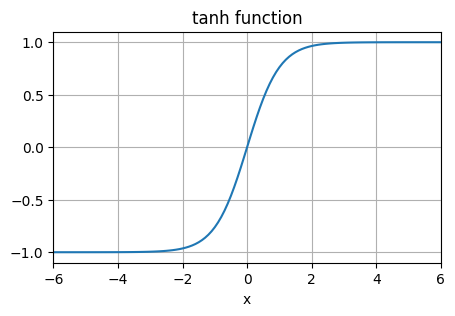

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-6, 6, 121)
y = (np.exp(x)- np.exp(-x)) / (np.exp(x) + np.exp(-x))
plt.figure(figsize=(5, 3))
plt.plot(x, y)
plt.grid()
plt.xlim(-6, 6)
plt.xlabel('x')
plt.title('tanh function')
plt.show()

## 사전 작업

문장 분류 모델을 학습시키기 위한 사전 작업을 진행해보겠습니다. 데이터 셋을 불러오고, 토크나이저와 데이터 셋, 데이터 로더를 작성하겠습니다.

### 데이터 셋 준비

### tokenizer 준비

In [ ]:
!pip install tokenizers

DEPRECATION: pytorch-lightning 1.8.3.post1 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: mecab-python 0.996-ko-0.9.2 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of mecab-python or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Dataset

In [1]:
from torch.utils.data import Dataset

class CustomTextDataset(Dataset):
    def __init__(self, corpus_df, transform=None):
        self.corpus_df = corpus_df
        self.transform = transform

    def __len__(self):
        return len(self.corpus_df)

    def __getitem__(self, idx):
        text, label = self.corpus_df.iloc[idx]
        return text, label

### DataLoader

dataloader 구현 시에 배치 내 각 문장별 토큰 개수를 집계한 batch_lengths를 추가로 리턴해주도록 합니다. 이는 RNN 학습 시에 pack_padded_sequence를 사용하기 위함이입니다.

In [ ]:
MAX_TOKENS = 256
BATCH_SIZE = 128

In [ ]:
vocabs = tokenizer.get_vocab()
pad_token = vocabs["[PAD]"]

In [2]:
import torch
from torch.nn.utils.rnn import pad_sequence

def _tokenize(text):
    tokens = tokenizer.encode(text).ids
    tokens = tokens[:MAX_TOKENS]
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    return token_tensor

def collate_fn(batch):
    batch_text = [x[0] for x in batch]
    batch_label = torch.tensor([x[1] for x in batch], dtype=torch.long)
    batch_tokens = [_tokenize(x) for x in batch_text]
    batch_padded = pad_sequence(batch_tokens, padding_value=pad_token)
    return batch_padded, batch_label

### pack_padded_sequence

padding을 추가하게 되면 시퀀스 뒤에 0이 붙게 됩니다. 이는 길이를 맞추기 위함으로 실제 의미는 없습니다. 그런데 이를 그대로 RNN에 전달하면, 추가된 0만큼 불필요한 계산을 하게 됩니다.

이를 방지하기 위해서 torch가 제공하는 기능이 pack_padded_sequence입니다. 먼저 예시 문장들을 토큰화 한 뒤, 패딩을 채워보겠습니다.

In [5]:
samples = ["꿀잼", "노잼 비추", "감동적인 대작!! 울면서 봤습니다."]

이를 pack_padded_sequence를 이용해서 압축해보겠습니다.

pack_padded_sequence 결과를 보면 기존에 0으로 채워졌던 부분들이 제거되고 데이터들이 일렬로 펼쳐진 것을 확인할 수 있습니다. batch_sizes는 각 행마다 0이 아닌 값들의 개수를 집계한 숫자입니다. sorted_index는 0이 아닌 토큰 값들이 많은 열을 정렬한 결과입니다.

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/5.png)

data는 결국 각 행마다 0이 아닌 값들을 일렬로 펼쳐서 이어붙인 결과로 볼 수 있습니다. batch_size와 sorted_index를 이용하면 원래의 형태로 복원이 가능합니다.

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/6.png)

### pad_packed_sequence
torch에서 제공하는 pad_packed_sequence 함수를 사용하면 다시 원래의 상태로 복원할 수 있습니다.

torch를 이용해서 RNN 모델을 학습시킬 때, 학습을 빠르게 진행시키기 위해서는 RNN 통과 전에 pack_padded_sequence를 해주고, RNN을 통과시킨 이후에 pad_padded_sequence를 해주어 보원시켜주면 됩니다.

## RNN 문장 분류 모델 학습

이제 RNN을 이용해서 문장을 분류하는 모델을 만들고, 이를 학습시켜보겠습니다. 전반적인 구조는 아래와 같습니다.

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/7.png)

### RNN 문장 분류 모델 작성

### 학습 코드 준비

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [ ]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

### 하이퍼 파라미터 셋팅

### 학습

## RNN 변형하기

방금 전에는 RNN을 1개 층만 쌓아서 학습을 시켜보았습니다. 이번에는 RNN 기본 구조를 약간 변형하여 학습시키는 기법들에 대해서 알아보겠습니다.

### bi-directional RNN

hidden state를 등장한 순서대로 흘려보내는 방식과, 역순으로 흘려보내는 방식을 모두 학습시키는 방법입니다. 여기서 얻은 마지막 시점의 hidden state를 Fully Connected Layer에 통과시킨 후, 예측 결과를 얻습니다.

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/8.png)

### RNN을 여러층 쌓기

방금 학습시킨 모델은 RNN을 1층만 쌓았습니다. RNN 레이어를 여러층 쌓고 싶다면, 모델을 만들 때, RNN layer에 num_layers 옵션을 변경해주면 됩니다. 한번 층을 추가하여 모델을 학습시켜보고 성능이 개선되는지 보겠습니다.

![1.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/9.png)

## 정리

이번 챕터에서는 RNN의 기본 개념과 torch를 이용해서 RNN을 학습시킬 수 있는 방법에 대해서 알아보았습니다. 그리도 bi-directional RNN과 multilayer RNN에 대해서 알아보았습니다. 구조가 다소 복잡하지만, 코드 구현은 간단했습니다.

디테일한 내용들에 너무 구애받지 말고, 이전 혹은 다음 입력값의 hidden state를 현재 값을 예측할 때 사용한다는 기본 개념만 확실히 기억하고 넘어가면 충분합니다.